In [1]:
#########
#
# Notebook to turn randomized SYNEX data (after tiling) into a base data frame.
# This is a much easier data structure to manipulate and takes much less time to load
# and analyse than loading all the detector savefiles after gwemopt is run.
# This also adds a layer of security. If you accidentally overwrite a dataframe or
# permanently change it, then you till still have the base dat and lisabeta files to
# recreate teh dataframe from.
#
#########

In [2]:
%matplotlib inline

# Set path to SYNEX
import os,sys
import pathlib
SYNEX_PATH=os.popen('pwd').read().split("/SYNEX/")[0]+"/SYNEX"
sys.path.insert(1, SYNEX_PATH)
# print(sys.path)
# sys.path.insert(1, os.path.join(sys.path[0], '..'))

In [3]:
import importlib
import numpy as np
import pandas as pd
import lisabeta.utils.plotutils as plotutils
import time
import glob
import copy
from astropy.cosmology import Planck13, z_at_value
from astropy.cosmology import WMAP9 as cosmo
from astropy.time import Time
import json
import healpy as hp
import gwemopt
from gwemopt import utils as gou
import SYNEX
from SYNEX import SYNEX_Utils as SYU
from SYNEX import SYNEX_Detectors as SYDs
from SYNEX import SYNEX_Telescopes as SYTs
from SYNEX import SYNEX_Sources as SYSs
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as pylab
from SYNEX.SYNEX_Utils import pylab_params
pylab.rcParams.update(pylab_params)
importlib.reload(SYU)

<module 'SYNEX.SYNEX_Utils' from '/Users/baird/Documents/LabEx_PostDoc/SYNEX/SYNEX/SYNEX_Utils.py'>

In [4]:
# Grab all available systems
T0 = time.time()
AthenaSaves=glob.glob(SYNEX_PATH+"/Saved_Telescope_Dicts/Randomized_SYNEX2/Randomized_*.dat")
print(len(AthenaSaves),"randomized SYNEX Athena savefiles found. Forming list of telescope objects [this may take some time]...")
Athenas=[SYDs.Athena(**{"ExistentialFileName":f,"verbose":False}) for f in AthenaSaves[:50]]
T1 = time.time()
print("Time to load all LISA objects:",(T1-T0)/60.,"min")


4408 randomized SYNEX Athena savefiles found. Forming list of telescope objects [this may take some time]...
Time to load all LISA objects: 0.5656367301940918 min


In [24]:
# Check savefile substructures (these might be different on cluster and therefore need changing to local copies of objects.)
print(AthenaSaves[0])
print(Athenas[0].ExistentialFileName)
print(Athenas[0].telescope_source_coverage["source save file"])
print(Athenas[0].telescope_source_coverage["source JsonFile"])
print(Athenas[0].telescope_source_coverage["source H5File"])

print("\n")

# Need to change location of Json files since paths are simple on cluster but have substucture locally
NoJsonFileCount=0
NoH5FileCount=0
for ii in range(len(Athenas)):
    if not os.path.isfile(Athenas[ii].telescope_source_coverage["source JsonFile"]):
        NoJsonFileCount+=1
        OldJson=Athenas[ii].telescope_source_coverage["source JsonFile"]
        NewJson = SYNEX_PATH+"/inference_param_files/Randomized_SYNEX2/"+OldJson.split("/")[-1]
        Athenas[ii].telescope_source_coverage["source JsonFile"] = NewJson
    if not os.path.isfile(Athenas[ii].telescope_source_coverage["source H5File"]):
        NoH5FileCount+=1
        Oldh5=Athenas[ii].telescope_source_coverage["source H5File"]
        Newh5 = SYNEX_PATH+"/inference_data/Randomized_SYNEX2/"+Oldh5.split("/")[-1]
        Athenas[ii].telescope_source_coverage["source H5File"] = Newh5

print("NoJsonFileCount",NoJsonFileCount)
print("NoH5FileCount",NoH5FileCount)


# Check if things are good now
NoJsonFileCount=0
NoH5FileCount=0
for ii in range(len(Athenas)):
    if not os.path.isfile(Athenas[ii].telescope_source_coverage["source JsonFile"]):
        NoJsonFileCount+=1
        print(Athenas[ii].telescope_source_coverage["source JsonFile"])
    if not os.path.isfile(Athenas[ii].telescope_source_coverage["source H5File"]):
        NoH5FileCount+=1
        print(Athenas[ii].telescope_source_coverage["source H5File"])


print("NoJsonFileCount",NoJsonFileCount)
print("NoH5FileCount",NoH5FileCount)


for a in Athenas: print(a.telescope_source_coverage["source JsonFile"].split("/")[-1], a.telescope_source_coverage["source H5File"].split("/")[-1], a.telescope_source_coverage["source save file"], a.ExistentialFileName, "\n")


/Users/baird/Documents/LabEx_PostDoc/SYNEX/Saved_Telescope_Dicts/Randomized_SYNEX2/Randomized_angles_spins_MRat_SourceInd_77__Tobs_2.0_Tcut_14.0d.dat
/Users/baird/Documents/LabEx_PostDoc/SYNEX/Saved_Telescope_Dicts/Randomized_SYNEX2/Randomized_angles_spins_MRat_SourceInd_77__Tobs_2.0_Tcut_14.0d.dat
/Users/baird/Documents/LabEx_PostDoc/SYNEX/Saved_Source_Dicts/Randomized_SYNEX2/Randomized_angles_spins_MRat_77_2wk.dat
/Users/baird/Documents/LabEx_PostDoc/SYNEX/inference_param_files/Randomized_SYNEX2/Randomized_angles_spins_MRat_77_2wk.json
/Users/baird/Documents/LabEx_PostDoc/SYNEX/inference_data/Randomized_SYNEX2/Randomized_angles_spins_MRat_77_2wk.h5


NoJsonFileCount 0
NoH5FileCount 0
NoJsonFileCount 0
NoH5FileCount 0
Randomized_angles_spins_MRat_77_2wk.json Randomized_angles_spins_MRat_77_2wk.h5 /Users/baird/Documents/LabEx_PostDoc/SYNEX/Saved_Source_Dicts/Randomized_SYNEX2/Randomized_angles_spins_MRat_77_2wk.dat /Users/baird/Documents/LabEx_PostDoc/SYNEX/Saved_Telescope_Dicts/Random

In [6]:
# Create data frame from Athena objects
SaveFile = 'Randomized_SYNEX2/data.h5'
data = SYU.GetDataFrame(telescopes=Athenas,SaveFile=SaveFile) # Both inputs given so any existing SaveFile will be overwritten. 
data.head(10)


Saving dataframe to: /Users/baird/Documents/LabEx_PostDoc/SYNEX/DataFrames/Randomized_SYNEX2/data.h5


,M,q,chi1,chi2,lambda,beta,dist,DeltatL_cut,Tobs,exposuretime,n_photons_per_tile,n_photons,DaysToSourceExp,Fisher Area (sq deg),Posterior Area (sq deg)
0,8000000,4.788733,0.756347,0.952624,-0.484569,-0.992868,9318.502184,-1209600.0,2.0,10000.0,[0],0,[[nan]],9.265445,41252.405477
1,8000000,4.224729,0.706799,0.472480,-2.142993,1.055390,9318.502184,-86400.0,1.0,10000.0,[0],0,[[nan]],9.265445,41252.405477
2,8000000,1.593099,0.255201,0.489022,-2.842312,0.392800,9318.502184,-36000.0,2.0,10000.0,[0],0,[[nan]],9.265445,41252.405477
3,8000000,8.128960,0.116872,0.571060,1.136092,-1.040920,9318.502184,-604800.0,2.0,10000.0,"[283.4607514991899, 283.4607514991899]",567,"[[1.157407407372375, 1.2731481481096125], [1.2...",9.265445,41252.405477
4,8000000,3.764520,0.461463,0.253972,-1.349690,-1.342834,9318.502184,-1209600.0,0.5,10000.0,[0],0,[[nan]],9.265445,41252.405477
5,8000000,2.576591,0.129745,0.079348,0.745675,0.578342,9318.502184,-36000.0,0.5,10000.0,[0],0,[[nan]],9.265445,41252.405477
6,8000000,5.465979,0.100822,0.517238,1.071474,-0.129429,9318.502184,-36000.0,0.5,10000.0,[0],0,[[nan]],9.265445,41252.405477
7,8000000,3.412919,0.622748,0.667324,-2.187310,-0.749555,9318.502184,-1209600.0,0.5,10000.0,"[114.09613709631981, 113.4344394408758]",228,"[[0.0, 0.1157407407372375], [0.115740740737237...",9.265445,41252.405477
8,8000000,2.822438,0.085546,0.205198,2.252548,-0.493335,9318.502184,-604800.0,0.5,10000.0,[0],0,[[nan]],9.265445,41252.405477
9,8000000,1.315029,0.146625,0.806522,2.025156,-0.417876,9318.502184,-259200.0,0.5,10000.0,[0],0,[[nan]],9.265445,41252.405477


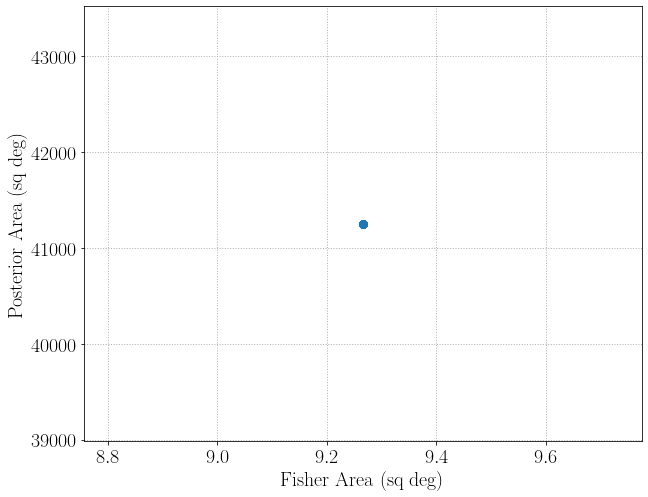

In [7]:
%matplotlib inline
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.labelsize'] = 20
LamBetScatter = data.plot.scatter(x="Fisher Area (sq deg)",y="Posterior Area (sq deg)",s=50,figsize=(10, 8))
plt.show()



In [8]:
# TMP code to fix source sky map problem
for ii in range(len(Athenas)):
    source=SYU.GetSourceFromLisabetaData(Athenas[ii].telescope_source_coverage["source JsonFile"], **{"verbose":False})
    # source.CreateSkyMapStruct()
    
    # Calculate sky areas
    source.PostSkyArea = source.calculatePostSkyArea()
    source.FisherSkyArea = source.calculateFisherSkyArea()
    
    # Reset saved areas in detector object
    Athenas[ii].telescope_source_coverage["source fisher area"] = source.FisherSkyArea
    Athenas[ii].telescope_source_coverage["source post area"] = source.PostSkyArea


Post area checks: 13 0.9193245778586399 14 13.91932457785864 3.357174580844667 46.72960265531346
Post area checks: 13 0.9193245778586399 14 13.91932457785864 3.357174580844667 46.72960265531346
Post area checks: 14 0.21135646687565157 15 14.211356466875651 3.357174580844667 47.71000468991741
Post area checks: 14 0.21135646687565157 15 14.211356466875651 3.357174580844667 47.71000468991741
Post area checks: 0 1.0 1 1.0 3.357174580844667 3.357174580844667
Post area checks: 0 1.0 1 1.0 3.357174580844667 3.357174580844667
Post area checks: 3 0.9011188811150054 4 3.9011188811150053 3.357174580844667 13.096737144532485
Post area checks: 3 0.9011188811150054 4 3.9011188811150053 3.357174580844667 13.096737144532485
Post area checks: 3 0.6301029463980645 4 3.6301029463980647 3.357174580844667 12.186889337496915
Post area checks: 3 0.6301029463980645 4 3.6301029463980647 3.357174580844667 12.186889337496915
Post area checks: 1 0.7931352459018218 2 1.793135245901822 3.357174580844667 6.019868067

In [13]:
# Check some sort of correlation ratio or factor
for Athena in Athenas:
    print(Athena.telescope_source_coverage["source fisher area"], Athena.telescope_source_coverage["source post area"])



7213.837625370863 46.72960265531346
2374.948987469151 47.71000468991741
30.935235588367913 3.357174580844667
885.1504018846317 13.096737144532485
1888.3294188010634 12.186889337496915
3749.461680882737 6.0198680675582485
124.93655344190148 5.917595767716339
8050.60219699615 0.0
3970.4144193182283 3.9980321164648163
3109.42526003258 61.100577371369994
5292.230349310165 3.357174580844667
254.43630768452047 3.357174580844667
559.5142154332661 3.357174580844667
12526.347313714103 12.499668879622954
1697.537729715865 3.357174580844667
1518.6719957728922 4.499678683767939
942.6154688383016 3.357174580844667
20439.77016879791 0.0
536.7350847440381 5.657526103712868
7760.143767821089 5.362914714819437
1374.7410310337584 6.15389811077332
2675.19486417513 3.357174580844667
4964.3344638894005 3.357174580844667
5276.621200997302 168.8891489630798
3118.1369478051593 3.357174580844667
3077.5228776472263 3.357174580844667
334.76788176440226 3.357174580844667
9739.006566056602 5.314054423373398
19127.

Post area checks: 13 0.9193245778586399 14 13.91932457785864 3.357174580844667 46.72960265531346
Post area checks: 13 0.9193245778586399 14 13.91932457785864 3.357174580844667 46.72960265531346
Randomized_angles_spins_MRat_96_3wk.json
Randomized_angles_spins_MRat_96_3wk.h5
36000 288000
8.0
7213.837625370863 7213.837625370863 46.72960265531346 46.72960265531346
Posterior sample length: 36000, number of infered parameters: 8


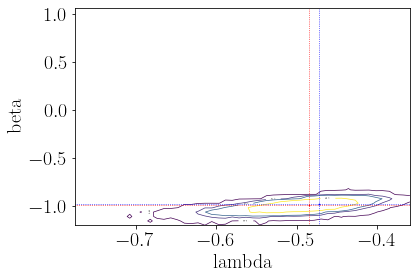

0.0 180.0 -180.0 180.0


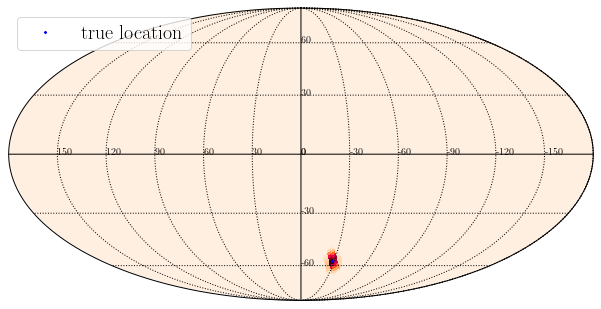

Post area checks: 0 1.0 1 1.0 3.357174580844667 3.357174580844667
Post area checks: 0 1.0 1 1.0 3.357174580844667 3.357174580844667
Randomized_angles_spins_MRat_96_3wk.json
Randomized_angles_spins_MRat_96_3wk.h5
36000 288000
8.0
5292.230349310165 5292.230349310165 3.357174580844667 3.357174580844667
Posterior sample length: 36000, number of infered parameters: 8


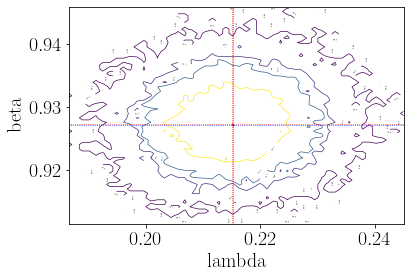

0.0 180.0 -180.0 180.0


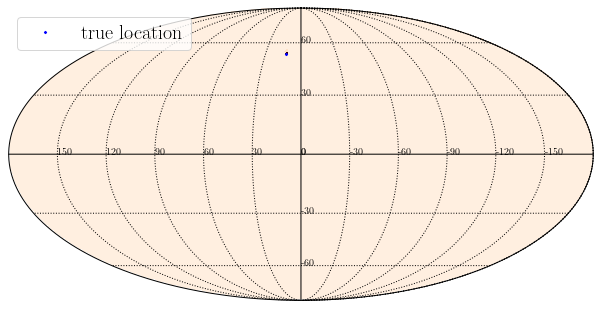

Post area checks: 1 0.8330587113003207 2 1.8330587113003207 3.357174580844667 6.15389811077332
Post area checks: 1 0.8330587113003207 2 1.8330587113003207 3.357174580844667 6.15389811077332
Randomized_angles_spins_MRat_96_3wk.json
Randomized_angles_spins_MRat_96_3wk.h5
36000 288000
8.0
1374.7410310337584 1374.7410310337584 6.15389811077332 6.15389811077332
Posterior sample length: 36000, number of infered parameters: 8


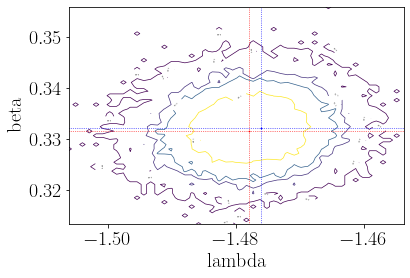

0.0 180.0 -180.0 180.0


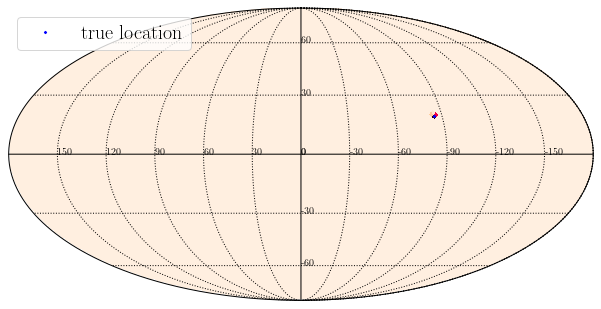

Post area checks: 0 1.0 1 1.0 3.357174580844667 3.357174580844667
Post area checks: 0 1.0 1 1.0 3.357174580844667 3.357174580844667
Randomized_angles_spins_MRat_96_3wk.json
Randomized_angles_spins_MRat_96_3wk.h5
1056 288000
272.72727272727275
7076.759076265352 7076.759076265352 3.357174580844667 3.357174580844667
Posterior sample length: 1056, number of infered parameters: 8


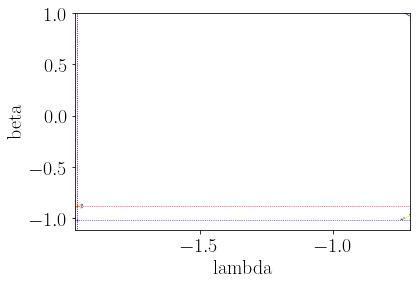

0.0 180.0 -180.0 180.0


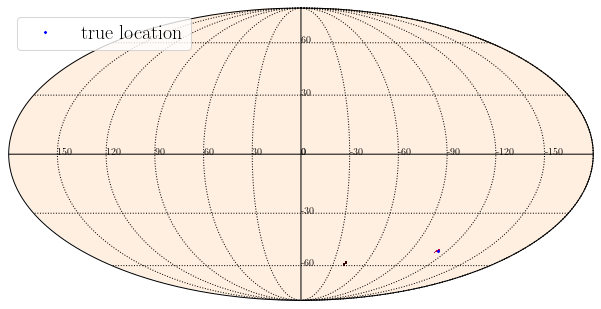

Post area checks: 7 0.33930348258918097 8 7.339303482589181 3.357174580844667 24.63932309285314
Post area checks: 7 0.33930348258918097 8 7.339303482589181 3.357174580844667 24.63932309285314
Randomized_angles_spins_MRat_96_3wk.json
Randomized_angles_spins_MRat_96_3wk.h5
36000 288000
8.0
12752.1001095979 12752.1001095979 24.63932309285314 24.63932309285314
Posterior sample length: 36000, number of infered parameters: 8


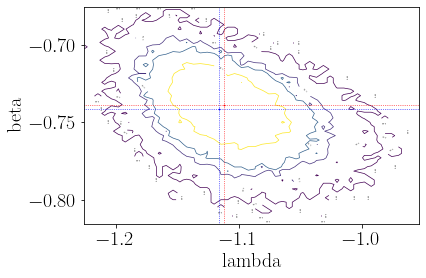

0.0 180.0 -180.0 180.0


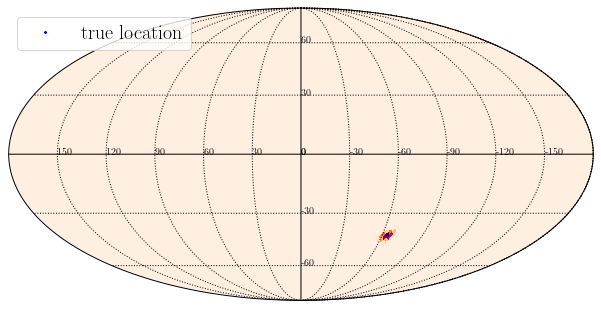

Post area checks: 1 0.7884843102428658 2 1.7884843102428658 3.357174580844667 6.004254064586856
Post area checks: 1 0.7884843102428658 2 1.7884843102428658 3.357174580844667 6.004254064586856
Randomized_angles_spins_MRat_96_3wk.json
Randomized_angles_spins_MRat_96_3wk.h5
36000 288000
8.0
30416.66137406616 30416.66137406616 6.004254064586856 6.004254064586856
Posterior sample length: 36000, number of infered parameters: 8


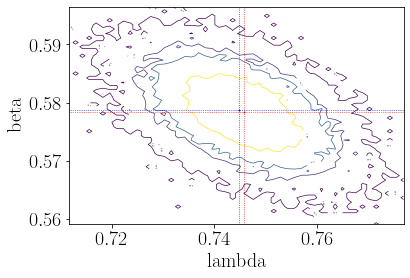

0.0 180.0 -180.0 180.0


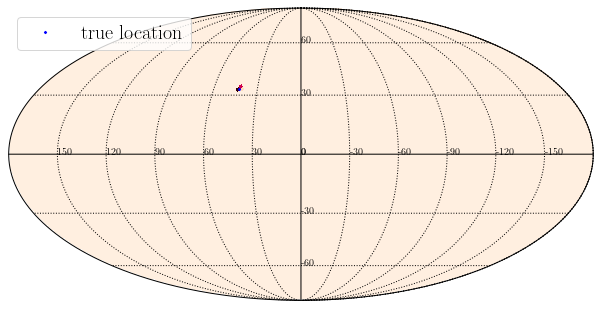

In [31]:
# Check some example skymaps
for ii in [0, 10, 20, 30, 40, 49]: # range(len(Athenas)):
    Merger=SYU.GetSourceFromLisabetaData(Athenas[ii].telescope_source_coverage["source JsonFile"], **{"verbose":False})
    
    # Calculate sky areas
    Merger.PostSkyArea = Merger.calculatePostSkyArea()
    Merger.FisherSkyArea = Merger.calculateFisherSkyArea()
    
    # Posterior ample length
    [infer_params, _, _, _] = SYU.read_h5py_file(Merger.H5File)
    if np.size(infer_params["lambda"][0])>1:
        nsamples = len(infer_params["lambda"][0])
    else:
        nsamples = len(infer_params["lambda"])
    
    # Json sample lengths
    with open(Merger.JsonFile) as f: data = json.load(f)
    run_params = data["run_params"]
    
    # Print some stuff
    print(a.telescope_source_coverage["source JsonFile"].split("/")[-1])
    print(a.telescope_source_coverage["source H5File"].split("/")[-1])
    print(nsamples, (run_params["n_iter"]-run_params["burn_in"])*run_params["n_walkers"])
    print((run_params["n_iter"]-run_params["burn_in"])*run_params["n_walkers"]/nsamples) ### Autocorrelation length
    print(Merger.FisherSkyArea, Athenas[ii].telescope_source_coverage["source fisher area"], Merger.PostSkyArea, Athenas[ii].telescope_source_coverage["source post area"])
    
    # Plot
    SYU.PlotInferenceLambdaBeta(Athenas[ii].telescope_source_coverage["source JsonFile"], bins=50, SkyProjection=False, SaveFig=False, return_data=False)
    SYU.PlotSkyMapData(Merger,SaveFig=False,plotName=None)
    



In [32]:
# Grab new data
Fishers = [Athena.detector_source_coverage["source fisher area"] for Athena in Athenas]
Posts = [Athena.detector_source_coverage["source post area"] for Athena in Athenas]


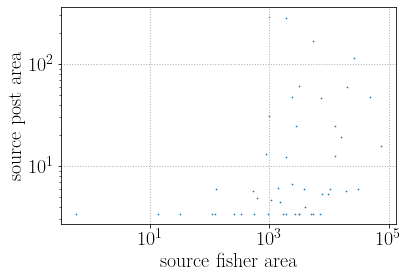

Conversion factors: 0.00030461741978670857 3282.806350011744
Max sky area: 41,252.96125 sq. deg, 12.56637 sq. rad.


In [33]:
# Plot new data to make sure things have changed

plt.scatter(Fishers,Posts)
ax=plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel("source fisher area")
plt.ylabel("source post area")
plt.show()

#plt.scatter([f for f,p in zip(Fishers,Posts) if p>10000], [p for p in Posts if p>10000])
#ax=plt.gca()
#ax.set_yscale('log')
#ax.set_xscale('log')
#plt.xlabel("source fisher area")
#plt.ylabel("source post area")
#plt.show()

#plt.scatter([f for f,p in zip(Fishers,Posts) if p<10000], [p for p in Posts if p<10000])
#ax=plt.gca()
#ax.set_yscale('log')
#ax.set_xscale('log')
#plt.xlabel("source fisher area")
#plt.ylabel("source post area")
#plt.show()

print("Conversion factors:",(np.pi/180)**2, (180/np.pi)**2)
print("Max sky area: 41,252.96125 sq. deg, 12.56637 sq. rad.")


In [ ]:
# Get indices of high and low posterior areas
HighSkyMapInds = [i for i,p in enumerate(Posts) if p>10000]
LowSkyMapInds = [i for i,p in enumerate(Posts) if p<10000]
print(HighSkyMapInds)
print(LowSkyMapInds)

# Inds to plot
PlotInds = [0, 1, 2, 4, 6, 10, 15, 18, 22, 27, 30]


# Plot some example high skymaps
#for ii in PlotInds:
#    Merger=SYU.GetSourceFromLisabetaData(Athenas[HighSkyMapInds[ii]].detector_source_coverage["source JsonFile"], **{"verbose":False})
#    SYU.PlotSkyMapData(Merger,SaveFig=False,plotName=None)
#    print(Fishers[HighSkyMapInds[ii]], Posts[HighSkyMapInds[ii]], "\n")

# Plot some example low skymaps
for ii in PlotInds:
    Merger=SYU.GetSourceFromLisabetaData(Athenas[LowSkyMapInds[ii]].telescope_source_coverage["source JsonFile"], **{"verbose":False})
    SYU.PlotSkyMapData(Merger,SaveFig=False,plotName=None)
    print(Fishers[LowSkyMapInds[ii]], Posts[LowSkyMapInds[ii]], Fishers[LowSkyMapInds[ii]]/Posts[LowSkyMapInds[ii]], "\n")


In [ ]:
# If we're happy, let's save everything for each detector
# for ii in range(len(Athenas)): Athenas[ii].ExistentialCrisis()